# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [2]:
RICE_QUANTITY_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/gia_lua_san_luong_xang.csv"

In [3]:
var_file_name = 'var_gia_lua_xang.joblib'
varma_file_name = 'varma_gia_lua_xang.joblib'


## VAR MODEL

Mô hình VAR (vector autoregressive models) được sử dụng cho chuỗi thời gian đa biến. Cấu trúc của nó là mỗi biến là một hàm tuyến tính của các lag của chính nó và các lag của các biến khác

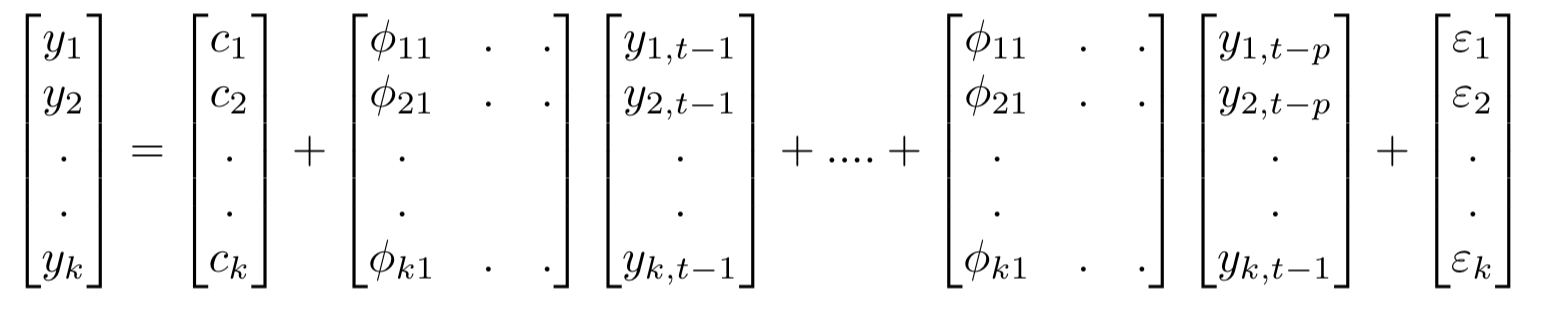

In [4]:
df = pd.read_csv(RICE_QUANTITY_URI)

In [5]:
df.set_index('date', inplace=True)

In [6]:
df.head()

,price,area,productivity,quantity,RON 95-III
date,,,,,
8/22/2018,11000,235.0,73.5,1727.4,21.17
8/23/2018,11000,235.0,73.5,1727.4,21.17
8/24/2018,11000,235.0,73.5,1727.4,21.17
8/25/2018,11000,235.0,73.5,1727.4,21.17
8/26/2018,11000,235.0,73.5,1727.4,21.17


<Axes: >

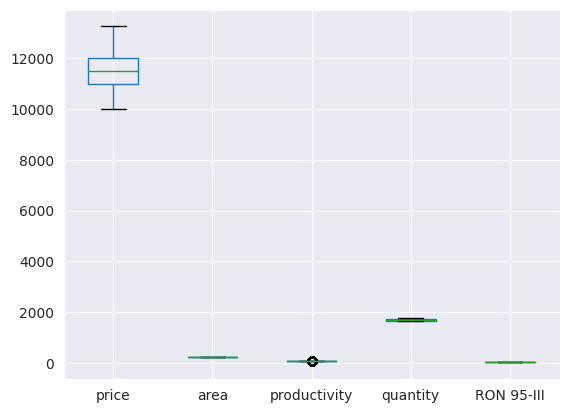

In [7]:
df.boxplot()

In [8]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 0


<Axes: >

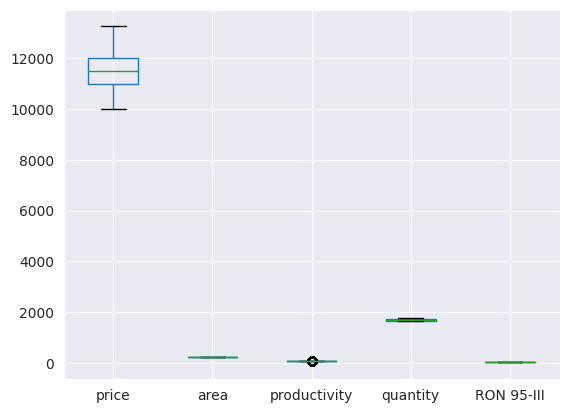

In [9]:
df.boxplot()

In [10]:
df = df.dropna()

In [11]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,area,productivity,quantity,RON 95-III
price,1.000000,-0.702874,0.517530,0.327297,0.435325
area,-0.702874,1.000000,-0.300639,-0.013457,-0.006957
productivity,0.517530,-0.300639,1.000000,0.957644,0.236627
quantity,0.327297,-0.013457,0.957644,1.000000,0.238497
RON 95-III,0.435325,-0.006957,0.236627,0.238497,1.000000


In [12]:
fillter_feature = ['price', 'area', 'productivity', 'quantity', 'RON 95-III']
df = df[fillter_feature]

In [13]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,area,productivity,quantity,RON 95-III
price,1.000000,-0.702874,0.517530,0.327297,0.435325
area,-0.702874,1.000000,-0.300639,-0.013457,-0.006957
productivity,0.517530,-0.300639,1.000000,0.957644,0.236627
quantity,0.327297,-0.013457,0.957644,1.000000,0.238497
RON 95-III,0.435325,-0.006957,0.236627,0.238497,1.000000


<Axes: xlabel='date'>

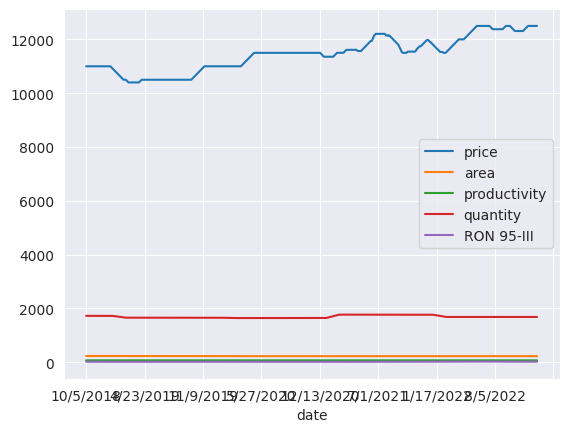

In [14]:
df = df.rolling(45).mean()
df = df.dropna()
df.plot()

In [15]:
nobs = int(len(df) * 0.8)
df_train, df_test = df[0:nobs], df[nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(1236, 5)
(309, 5)


In [16]:
from google.colab import files


## Kiểm tra stationary

In [17]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [18]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3371
 No. Lags Chosen       = 6
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.612. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "area" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9829
 No. Lags Chosen       = 1
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.2941. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "productivity" 
    -----------------------------------------------
 Null Hypothesis: Data has

In [19]:
df_differenced = df_train.diff().dropna()

In [20]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2715
 No. Lags Chosen       = 5
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "area" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8098
 No. Lags Chosen       = 0
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0028. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "productivity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Leve

## Train model

In [21]:
model = VAR(df_differenced)
for i in range(1, 50):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -43.150567277475
BIC :  -43.02614224819302
FPE :  1.8194784108749872e-19
HQIC:  -43.10376197454309 

Lag Order = 2
AIC :  -43.111928982403434
BIC :  -42.8836675852631
FPE :  1.8911595348039583e-19
HQIC:  -43.026059827565014 

Lag Order = 3
AIC :  -43.08119549775585
BIC :  -42.748962111775754
FPE :  1.9501934470626906e-19
HQIC:  -42.956208334547625 

Lag Order = 4
AIC :  -43.043686023643836
BIC :  -42.607344737494884
FPE :  2.024752143467171e-19
HQIC:  -42.87952657649624 

Lag Order = 5
AIC :  -43.01130475982162
BIC :  -42.47071937096988
FPE :  2.0914204976162212e-19
HQIC:  -42.807918633701576 

Lag Order = 6
AIC :  -42.9744185643962
BIC :  -42.32945257824263
FPE :  2.1700532736138274e-19
HQIC:  -42.73175124444859 

Lag Order = 7
AIC :  -42.949141633140904
BIC :  -42.19965826215778
FPE :  2.2256725954618683e-19
HQIC:  -42.667138484328625 

Lag Order = 8
AIC :  -42.93795728967481
BIC :  -42.083819452538926
FPE :  2.250795985868823e-19
HQIC:  -42.6165635564175 

Lag O

In [22]:
x = model.select_order(maxlags=50)
x.summary()

,AIC,BIC,FPE,HQIC
0,-28.42,-28.40,4.554e-13,-28.41
1,-42.99,-42.86*,2.141e-19,-42.94*
2,-42.95,-42.72,2.220e-19,-42.86
3,-42.92,-42.58,2.283e-19,-42.79
4,-42.89,-42.44,2.364e-19,-42.72
5,-42.86,-42.30,2.434e-19,-42.65
6,-42.83,-42.16,2.518e-19,-42.58
7,-42.80,-42.03,2.576e-19,-42.51
8,-42.79,-41.92,2.597e-19,-42.46
9,-42.77,-41.79,2.659e-19,-42.40


In [23]:
model_var = model.fit(47)
model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Jun, 2024
Time:                     07:06:41
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -38.2100
Nobs:                     1188.00    HQIC:                  -41.3541
Log likelihood:           18445.4    FPE:                1.68219e-19
AIC:                     -43.2558    Det(Omega_mle):     6.79839e-20
--------------------------------------------------------------------
Results for equation price
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.040747         0.085888            0.474           0.635
L1.price                 0.917208         0.032243           28.447           0.000
L1.area               -520.312772       476.0239

In [24]:
def adjust(val, length= 6): return str(val).ljust(length)

In [25]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_var.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

price  : 2.01
area   : 2.0
productivity : 2.0
quantity : 2.0
RON 95-III : 2.0


In [26]:
# Get the lag order
lag_order = model_var.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

47


array([[-1.11111111e+01, -1.33333333e-02, -7.77777778e-02,
        -1.90888889e+00, -3.77777778e-02],
       [-1.11111111e+01, -1.33333333e-02, -7.77777778e-02,
        -1.90888889e+00, -3.77777778e-02],
       [-1.11111111e+01, -1.33333333e-02, -7.77777778e-02,
        -1.90888889e+00, -3.77777778e-02],
       [-1.11111111e+01, -1.33333333e-02, -7.77777778e-02,
        -1.90888889e+00, -1.35555556e-02],
       [-1.11111111e+01, -1.33333333e-02, -7.77777778e-02,
        -1.90888889e+00, -1.35555556e-02],
       [-1.11111111e+01, -1.33333333e-02, -7.77777778e-02,
        -1.90888889e+00, -6.66666667e-04],
       [-1.11111111e+01, -1.33333333e-02, -7.77777778e-02,
        -1.90888889e+00, -6.66666667e-04],
       [-1.11111111e+01, -1.33333333e-02, -7.77777778e-02,
        -1.90888889e+00, -6.66666667e-04],
       [-1.11111111e+01, -1.33333333e-02, -7.77777778e-02,
        -1.90888889e+00, -6.66666667e-04],
       [-1.11111111e+01, -1.33333333e-02, -7.77777778e-02,
        -1.90888889e+00

In [27]:
import joblib
joblib.dump(model_var, 'var_gia_lua.joblib')

['var_gia_lua.joblib']

In [28]:
from google.colab import files
files.download('var_gia_lua.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Forecast
nobs = len(df_test)
fc = model_var.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,price_2d,area_2d,productivity_2d,quantity_2d,RON 95-III_2d
date,,,,,
2/22/2022,9.417426,0.000425,0.001385,0.035361,0.067370
2/23/2022,6.501034,0.001491,0.003946,0.103013,0.054159
2/24/2022,4.861816,0.002404,0.005399,0.143690,0.051530
2/25/2022,5.531414,0.003752,0.010275,0.266230,0.044496
2/26/2022,3.597257,0.003742,0.010440,0.270157,0.047659
...,...,...,...,...,...
12/23/2022,-0.058684,-0.003854,-0.000752,-0.046271,0.008218
12/24/2022,0.463631,-0.003603,-0.001839,-0.069749,0.009714
12/25/2022,0.230914,-0.003520,-0.002937,-0.094730,0.010049


In [30]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+ '_2d'].cumsum()
    return df_fc

In [31]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
df_results.loc[:, ['price_forecast']]

,price_forecast
date,
2/22/2022,11553.861870
2/23/2022,11560.362904
2/24/2022,11565.224720
2/25/2022,11570.756134
2/26/2022,11574.353391
...,...
12/23/2022,11899.597814
12/24/2022,11900.061444
12/25/2022,11900.292358


### Đánh giá mô hình VAR

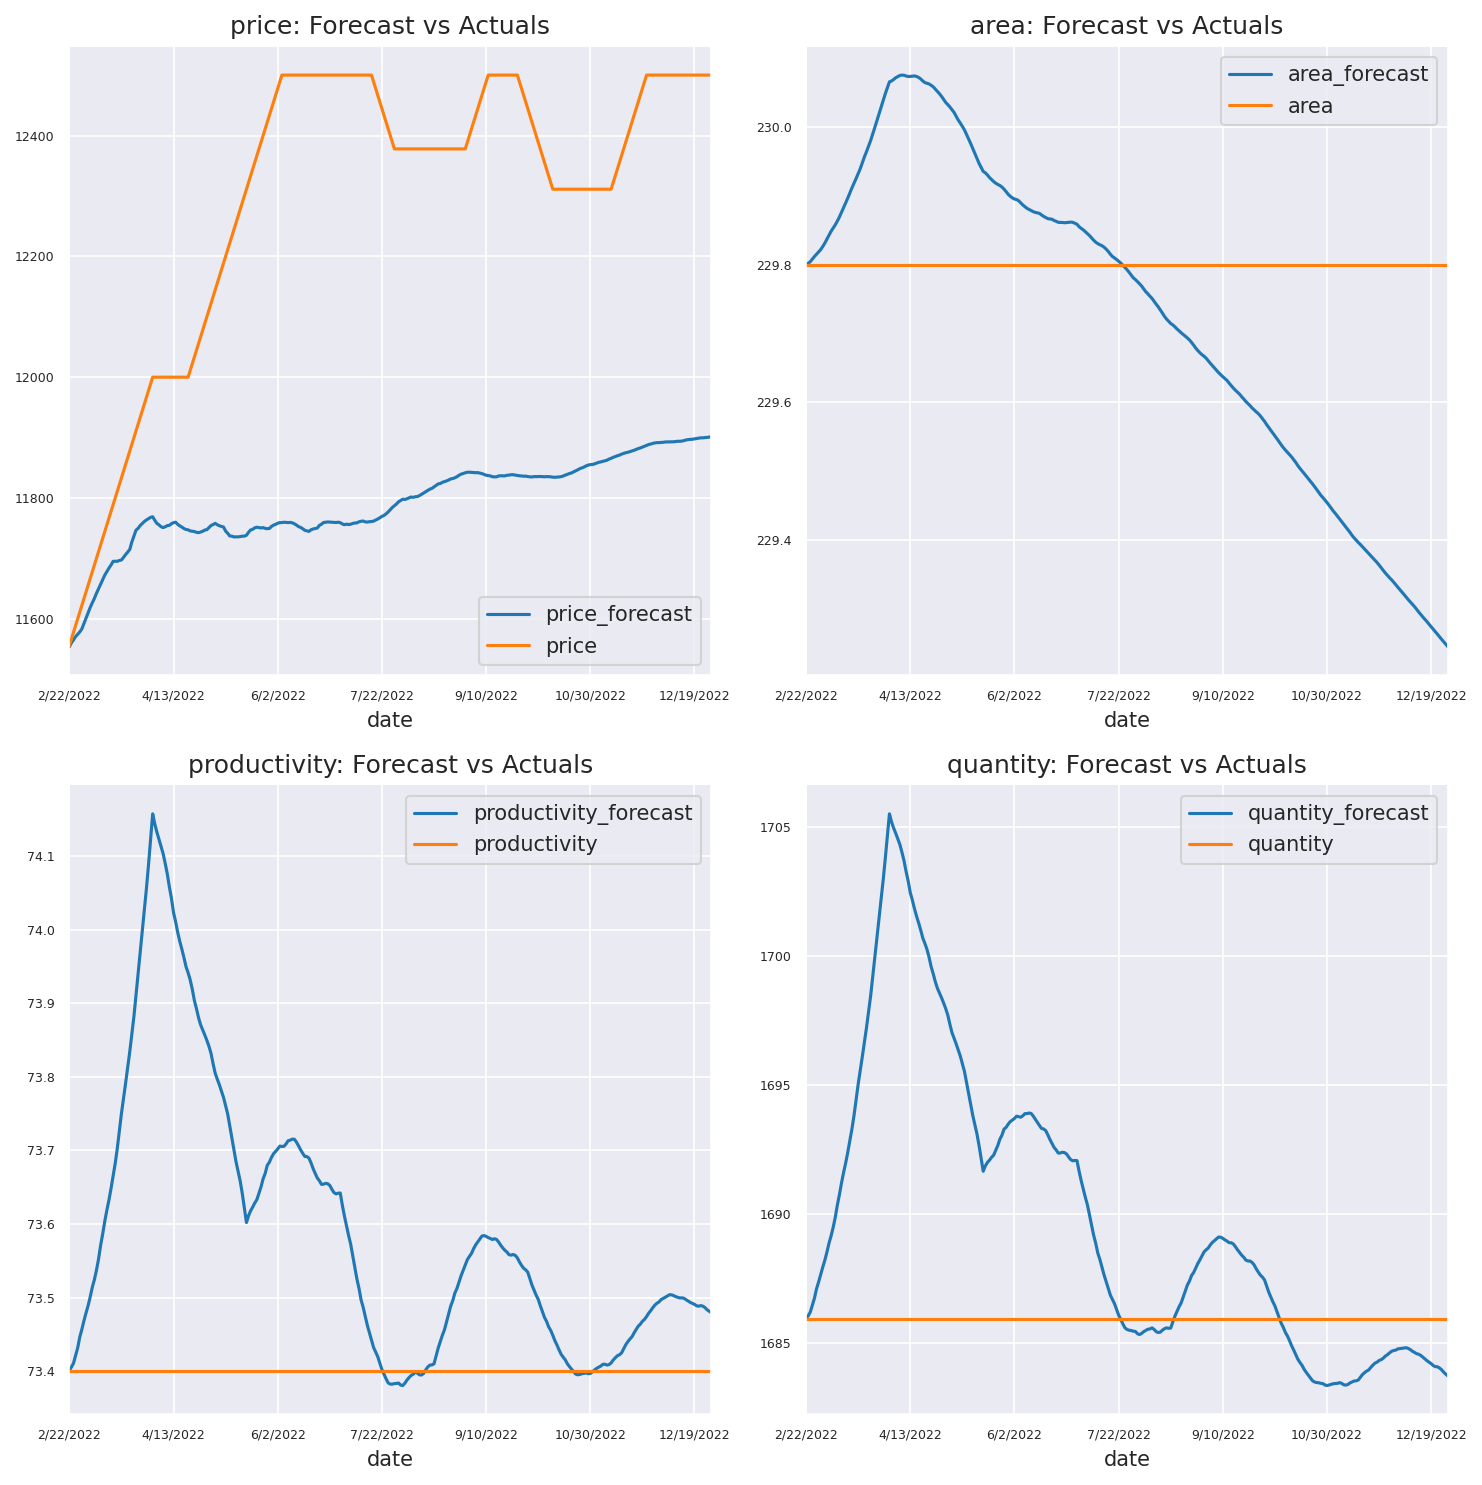

In [32]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [33]:
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_percentage_error
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100 # MAPE

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape,'rmse':rmse})

In [34]:
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  4.0722
rmse   :  543.7014


In [35]:
import joblib
joblib.dump(model_var, var_file_name)
from google.colab import files
files.download(var_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## VARMA Model

Mô hình Vector Autoregressive Moving Average (VARMA) là sự kết hợp của mô hình VAR và mô hình VMA, giúp trong việc mô hình hóa chuỗi thời gian đa biến bằng cách xem xét cả thứ tự của lag và thứ tự của trung bình di chuyển (p và q) trong mô hình.

In [36]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.7 MB/s eta 0:00:00


In [37]:
from pmdarima import auto_arima

In [38]:
columns_train = fillter_feature

In [39]:
pq = []
for name, column in df_differenced[columns_train].items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(df_differenced[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : price
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5811.496, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8252.682, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5812.723, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7173.207, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5813.359, Time=2.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5810.257, Time=0.42 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6598.765, Time=0.44 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5811.753, Time=1.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=5811.315, Time=0.84 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=6387.023, Time=0.59 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5810.426, Time=1.36 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5811.993, Time=1.31 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 9.278 seconds
optimal order for:price is: (1, 0, 2) 


Searchin

In [40]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics

In [41]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [42]:
# df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Open','RMSE High','RMSE Low','RMSE Close'])
# print('Grid Search Started')
# for i in pq:
#     if i[0]== 0 and i[2] ==0:
#         pass
#     else:
#         print(f' Running for {i}')
#         model = VARMAX(df_differenced[columns_train], order=(i[0],i[2])).fit( disp=False)
#         result = model.forecast(steps = 30)
#         inv_res = inverse_diff(df_train[columns_train], result)
#         Opensrmse = np.sqrt(metrics.mean_squared_error(df_test['price'][:30], inv_res['price_forecast']))

#         print(({'p': i[0], 'q': i[2], 'RMSE Open':Opensrmse}))


In [43]:
# from above example we can see that p=1 , q=2, tr=n gives least RMSE
model_varma = VARMAX(df_differenced[columns_train], order=(4,4),trends = 'n').fit( disp=False)


In [44]:
result = model_varma.forecast(steps = len(df_test))

In [45]:
inv_res = inverse_diff(df_train[columns_train], result)

Đánh giá mô hình

In [46]:
accuracy_prod = forecast_accuracy(inv_res['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

mape   :  3.012
rmse   :  403.9245


In [47]:
df_test.index = pd.to_datetime(df_test.index)
df_train.index = pd.to_datetime(df_train.index)

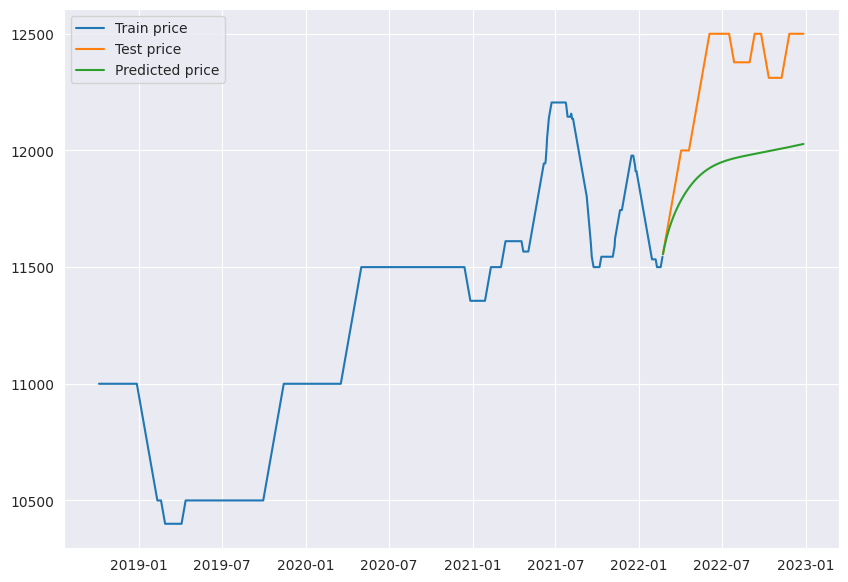

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['price']:

    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(df_train[str(i)], label='Train '+str(i))
    plt.plot(df_test[str(i)], label='Test '+str(i))
    plt.plot(inv_res[str(i)+'_forecast'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [50]:
import joblib
from google.colab import drive

drive.mount('/content/drive')

var_file_name = 'var_gia_lua_tong_hop.joblib'
varma_file_name = 'varma_gia_lua_tong_hop.joblib'

joblib.dump(model_varma, '/content/drive/MyDrive/model/' + varma_file_name)


joblib.dump(model_var, '/content/drive/MyDrive/model/' + var_file_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/model/var_gia_lua_tong_hop.joblib']